# Troubleshooting Web apps with Python and Pandas

Konrad Brodzik

20 April 2023

## Introduction

Data analysis tutorials usually fail to show how much work is required to get data into a digestable format.

We will be trying to root cause a performance problem in a distributed Web application.

The following case study is based on a real issue we've had with one of our applications. The logs, commits and performance data are artificially generated to meet confidentiality requirements.

This will be a live demo, but here's a link to the data and some setup instructions if you'd like to follow along: https://github.com/Kondziowy/data-analysis-workshop

While this will not be an in-depth class about Python, Pandas or Web apps, I will be happy to answer your questions :)

### Problem statement

Sally: "The website is loading slowly, can you fix it?"

Me: "What do you mean?"

Sally: "Umm, it loads slower than last week"

### App - description

- Web application - internal document management system
- 200 daily active users

![System diagram](img\system-diagram.png "Diagram" )

TODO: Add Github, have 2 front ends instead

### Our goals

1. Parse data that's available to us
1. De-noise the data
2. Have a quantitative measure of what's going wrong
3. Correlate different sources of data to find out the root cause of the problem
4. Aggregate data so we can use it for future failure detection

## Front End

What does it do? Serves static files (Javascript, images), forwards other requests to Gunicorn (reverse proxy).

Example log (a.k.a. access log):
```
127.0.0.1 - - [01/Apr/2023:11:27:40 +0000] "GET /index.html HTTP/1.1" 200 1200 0.002617
127.0.0.1 - - [01/Apr/2023:11:27:45 +0000] "GET /images/logo.png HTTP/1.1" 200 15734 0.007353
127.0.0.1 - - [01/Apr/2023:11:28:10 +0000] "POST /login HTTP/1.1" 302 - 0.014992
127.0.0.1 - - [01/Apr/2023:11:29:05 +0000] "GET /dashboard HTTP/1.1" 200 4369 0.100576
127.0.0.1 - - [01/Apr/2023:11:30:20 +0000] "GET /orders HTTP/1.1" 200 3520 0.006817
```

Information found here: request source, date, HTTP method, URL, protocol, response code, response size, processing time

### Parsing Front End logs

- Python find and split
- Regular Expressions
- Dedicated library

#### Find and split
1. Works for simple cases
2. Usually fast
3. Can be tricky to read and breaks easily

In [15]:
example_line = "127.0.0.1 - - [01/Apr/2023:11:27:40 +0000] \"GET \/index.html HTTP\/1.1\" 200 1200 0.002617"
entry_time = example_line[example_line.find("[") + 1:example_line.find("]")]
print(entry_time)

01/Apr/2023:11:27:40 +0000


#### Regular Expressions
1. Slightly higher learning curve
2. Full line matching validates if data is what you expect it to be
3. There are tools to help you - https://regex101.com/ or ChatGPT

In [48]:
import re
from collections import defaultdict

log_file = open('apache.log.big2', 'r')  # replace with the path to your log file

log_pattern = re.compile(
    r'(?P<IP>\d+\.\d+\.\d+\.\d+)\s-\s-\s\[(?P<Date>.*?)\]\s\"(?P<Method>POST|GET) (?P<Request>.*?) HTTP/1.1\"\s(?P<StatusCode>\d+)\s(?P<DataSize>\d+)\s(?P<RequestTime>.*?)$')

data_by_column = defaultdict(list)
lines_matched = 0
for idx, line in enumerate(log_file):
    match = log_pattern.match(line)
    if match is None:
        continue  # skip lines that don't match the pattern
    lines_matched += 1
    for column, value in match.groupdict().items():
        data_by_column[column].append(value)
print(f"Read {lines_matched} lines")
# print(idx)
# assert lines_matched == idx
log_file.close()

Read 30199 lines


### What to do next?

We need:
1. Aggregations - grouping, counting, averages
2. Extensibility - we will be adding more data from other sources

In [49]:
import pandas as pd

front_end_requests = pd.DataFrame(
  data_by_column
)
print(front_end_requests.shape)
print(front_end_requests.columns)
print(front_end_requests.info())
print(front_end_requests.Request.unique())
front_end_requests.head()

(30199, 7)
Index(['IP', 'Date', 'Method', 'Request', 'StatusCode', 'DataSize',
       'RequestTime'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30199 entries, 0 to 30198
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   IP           30199 non-null  object
 1   Date         30199 non-null  object
 2   Method       30199 non-null  object
 3   Request      30199 non-null  object
 4   StatusCode   30199 non-null  object
 5   DataSize     30199 non-null  object
 6   RequestTime  30199 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None
['/reviews?document_id=X' '/static/bootstrap.min.js' '/users'
 '/favicon.ico' '/images/logo.png' '/static/style.css'
 '/static/jquery-3.3.1.slim.min.js' '/document?id=X'
 '/documents?page=X&per_page=Y&filter=Z' '/']


,IP,Date,Method,Request,StatusCode,DataSize,RequestTime
0,192.168.190.31,03/Apr/2020:12:00:01 +0000,GET,/reviews?document_id=X,401,35958,0.491
1,192.168.174.126,03/Apr/2020:12:00:01 +0000,GET,/static/bootstrap.min.js,200,54514,0.748
2,192.168.62.99,03/Apr/2020:12:00:02 +0000,GET,/static/bootstrap.min.js,502,15286,0.077
3,192.168.224.201,03/Apr/2020:12:00:02 +0000,GET,/static/bootstrap.min.js,200,79632,0.942
4,192.168.184.218,03/Apr/2020:12:00:02 +0000,GET,/static/bootstrap.min.js,200,15954,0.323


### Figuring out the requests

In [50]:
# TODO: Explain index and columns

import matplotlib.pyplot as plt
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
front_end_requests['Date'] = pd.to_datetime(front_end_requests['Date'], format="%d/%b/%Y:%H:%M:%S %z")
# TODO: need to convert numbers as well!
front_end_requests['RequestTime'] = pd.to_numeric(front_end_requests['RequestTime'])
# front_end_requests.info()
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# 'T' is for minutes, 'S' for seconds
grouped_requests = front_end_requests.groupby(['Request', pd.Grouper(key='Date', axis=0, freq='T')]).count() # , 'Request', 'Method'
grouped_requests.head()
grouped_requests.index.get_level_values('Date').drop_duplicates()
# TODO: how to get values for specific date & request?
# grouped_requests.loc[('/users', '2020-04-03 12:04:00+00:00')]
# front_end_requests['Request'].describe()
front_end_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30199 entries, 0 to 30198
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   IP           30199 non-null  object             
 1   Date         30199 non-null  datetime64[ns, UTC]
 2   Method       30199 non-null  object             
 3   Request      30199 non-null  object             
 4   StatusCode   30199 non-null  object             
 5   DataSize     30199 non-null  object             
 6   RequestTime  30199 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 1.6+ MB


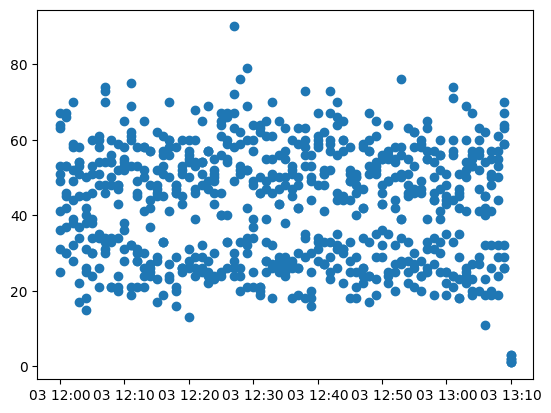

In [51]:
# grouped_requests.index.get_level_values('Date')
# Subsequent keys in a MultiIndex are called levels - https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.html
plt.plot(grouped_requests.index.get_level_values('Date'), grouped_requests['StatusCode'], 'o')
# TODO: add labels, improve date formatting
# TODO: explore individual vs vector multiplication in panadas

In [52]:
all_means = front_end_requests.groupby(['Request', pd.Grouper(key='Date', axis=0, freq='T')])['RequestTime'].mean()
# TODO: use to replace /static with static content
# all_means.index.where()
# Get
# front_end_requests['Request'].unique()
# X axis
all_means.filter(like='/users').index.get_level_values('Date')
# TODO: figure out better way
all_means.filter(like='/users')


Request  Date                     
/users   2020-04-03 12:00:00+00:00    0.479440
         2020-04-03 12:01:00+00:00    0.557867
         2020-04-03 12:02:00+00:00    0.485906
         2020-04-03 12:03:00+00:00    0.366000
         2020-04-03 12:04:00+00:00    0.505192
                                        ...   
         2020-04-03 13:06:00+00:00    1.788895
         2020-04-03 13:07:00+00:00    2.209563
         2020-04-03 13:08:00+00:00    2.164000
         2020-04-03 13:09:00+00:00    2.165231
         2020-04-03 13:10:00+00:00    1.546000
Name: RequestTime, Length: 71, dtype: float64

FIXME: / won't work with like operator
2020-04-03 12:01:00+00:00
0.4976333333333333


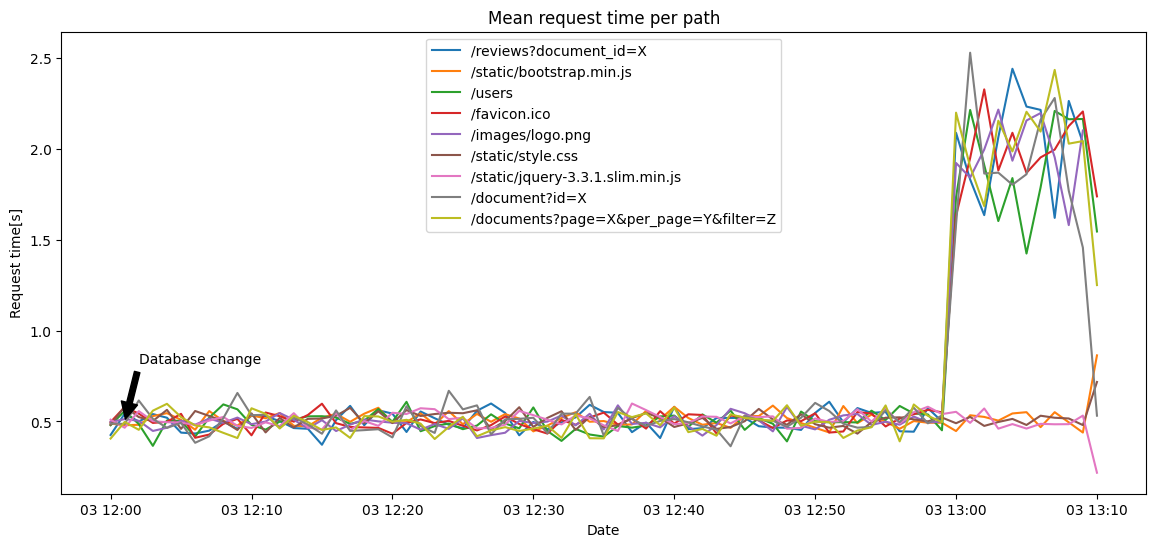

In [53]:
import matplotlib.dates
plt.figure(figsize=(14,6))
for idx, server_path in enumerate(front_end_requests['Request'].unique()):
    if server_path == '/':
        print("FIXME: / won't work with like operator")
        continue
    # https://datatofish.com/filter-pandas-dataframe/
    x_axis = all_means.filter(like=server_path).index.get_level_values('Date')
    y_axis = all_means.filter(like=server_path)
    # print(server_path)
    # print(x_axis)
    # print(y_axis)
    # https://matplotlib.org/stable/gallery/color/color_demo.html#sphx-glr-gallery-color-color-demo-py
    plt.plot(x_axis, y_axis, color=f"C{idx}", label=server_path)
plt.title("Mean request time per path")
plt.legend(loc="upper center")
plt.xlabel("Date")
plt.ylabel("Request time[s]")
print(x_axis[1])
print(y_axis[1])
# https://stackoverflow.com/questions/11067368/annotate-time-series-plot-in-matplotlib
# https://matplotlib.org/stable/tutorials/text/annotations.html#annotating-data
plt.annotate("Database change", xy=(x_axis[1], y_axis[1]), xycoords='data', xytext=(10, 50), textcoords='offset points', va='top', ha='left', arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
# A couple of problems here - graphs look like a mess, colors repeat

# TODO: if time allows - make date labels nicer
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
# TODO: Add Github labels
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_basic.html

### Saving your intermediate results

In [28]:
pd.to_pickle(all_means, "front_end_mean_times.pickle")
print(all_means.shape)
means_restored = pd.read_pickle("front_end_mean_times.pickle")
print(means_restored.shape)
all_means.to_csv("front_end_mean_times.csv")

(124,)
(124,)


### Front end logs - summary

- With text logs, there are different ways to parse them
- Regular expressions are a good solution in many cases but always consider your options
- We know API request times have increased at 8 AM on April 4, what do we do next?

## Back End

What does it do? Processes business logic, handles database communication. This is where your Flask, Django, FastAPI or Node.js application runs.

Example log:
```
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /documents?page=X&per_page=Y&filter=Z 200 3520 0.006817
[2022-04-01 13:37:00 +0000] [12345] [] [api.py:86] [INFO] Recording operation GET from user ellen
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /users 200 3128 0.006817
```

## Database

Read & writes data. Our example focuses on PostgreSQL internals but the same reasoning can be applied to any other database engine.

**Note**: PostgreSQL only serves current data in the `pg_stat_all_tables` view. We will be using a time series that has to be collected using other tools - e.g. Zabbix or Prometheus. For the sake of this excercise, assume we have a script that outputs theresult of this query every 5 seconds to an Sqlite database.

In [77]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('tps_database.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a SQL query
# cursor.execute("CREATE TABLE db_activity (timestamp TEXT NOT NULL, table_name TEXT NOT NULL, tuples_read INTEGER NOT NULL, tuples_write INTEGER NULL)")
# cursor.execute("INSERT INTO db_activity VALUES ('2023-04-22 10:00:00.436', 'users', 5, 0)")

In [78]:
db_stats = pd.read_sql("SELECT * FROM db_activity", conn)

In [79]:
db_stats.head()

,timestamp,table_name,tuples_read,tuples_write
0,2023-04-22 10:00:00.436,users,5,0


## Github

Github is used to deploy new versions of our system. For the sake of simplicity, let's assume commits get deployed to production immediately after being pushed to Git.

In [30]:
import json
import pprint

# https://docs.github.com/en/rest/commits/commits?apiVersion=2022-11-28
# url = f"https://api.github.com/repos/{owner}/{repo_name}/commits?sha={branch}"
# response = requests.get(url, headers=headers)
with open("data/github-output.json") as f:
    response = json.load(f)

pprint.pprint(response)


[{'author': {'avatar_url': 'https://avatars.githubusercontent.com/u/2988831?v=4',
             'events_url': 'https://api.github.com/users/Kondziowy/events{/privacy}',
             'followers_url': 'https://api.github.com/users/Kondziowy/followers',
             'following_url': 'https://api.github.com/users/Kondziowy/following{/other_user}',
             'gists_url': 'https://api.github.com/users/Kondziowy/gists{/gist_id}',
             'gravatar_id': '',
             'html_url': 'https://github.com/Kondziowy',
             'id': 2988831,
             'login': 'Kondziowy',
             'node_id': 'MDQ6VXNlcjI5ODg4MzE=',
             'organizations_url': 'https://api.github.com/users/Kondziowy/orgs',
             'received_events_url': 'https://api.github.com/users/Kondziowy/received_events',
             'repos_url': 'https://api.github.com/users/Kondziowy/repos',
             'site_admin': False,
             'starred_url': 'https://api.github.com/users/Kondziowy/starred{/owner}{/rep

In [31]:
for commit in response:
    print(f"Commit SHA: {commit['sha']}, Message: {commit['commit']['message']}, Date: {commit['commit']['author']['date']}")

Commit SHA: 87c5efe0f524f68e827cc970947dd245cef24ae8, Message: Merge pull request #2 from legoGoat/choosing-stuff

Choosing stuff, Date: 2022-01-25T14:02:16Z
Commit SHA: 6353805000ff4123ee8999948f252ebd9bd26b6f, Message: pomprawki, Date: 2022-01-25T13:41:51Z
Commit SHA: 5fc440fd1ee707d99b0bf2e25a08b6517cc326d1, Message: chyba działa :thonk:, Date: 2022-01-25T10:22:30Z
Commit SHA: 0d72ead2822a8a92236938aa54903bd32f1645be, Message: chyba działa :thonk:, Date: 2022-01-25T10:19:13Z
Commit SHA: f3b69ba1b74fcd4115973bfe2dbacbd924fa8bf2, Message: Merge pull request #1 from Kondziowy/fix_bad_uris

Only return correct URLs, Date: 2021-01-07T18:33:09Z
Commit SHA: 78ea3835e70d7704ae6495c26b63f95e7aefb573, Message: Only return correct URLs, Date: 2021-01-07T18:19:47Z
Commit SHA: a4ef7266cc138cd4c4eb8fd919e4dea3ef3e2f59, Message: Merge branch 'main' of github.com:Kondziowy/document-management-system, Date: 2021-01-07T17:22:26Z
Commit SHA: 26e0a42aac9ae734392a6458c90cdb52fc083240, Message: Install c

### Bringing it all together



## Further reading

"Pandas for Everyone: Python Data Analysis, First Edition", Daniel Y. Chen, Addison-Wesley 2018 (https://learning.oreilly.com/library/view/pandas-for-everyone/9780134547046/cover.xhtml)